In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.
/Users/noe/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
def test_sample(network, temperature=1.0, nsample=100000, plot=True):
    if nsample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=nsample)
    else:
        sample_x = []
        for i in range(int(nsample/100000)):
            _, sample_x_, _, _, _ = network.sample(temperature=temperature, nsample=nsample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [7]:
# reweighting
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], -2.5, 2.5, 100, sample=100, weights=np.exp(log_w))
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [8]:
def hist_weights(network):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = 0.5 * (bins[:-1] + bins[1:])
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [9]:
def test_mcmc(network, nsample):
    fig, axes = plt.subplots(2, 1, figsize=(7, 7))
    # test sampling
    gp_mcmc = GaussianPriorMCMC(network)#, std_z=[0.7, 1.0])
    Z, X, E, J = gp_mcmc.run(nsample)
    print('Transitions:', count_transitions(X[:, 0], -1, 1))
    axes[0].plot(X[:min(10000, nsample), 0])
    # plot PMF
    h, b = np.histogram(X[:, 0], bins=100)
    b = 0.5 * (b[:-1] + b[1:])
    F = -np.log(h)
    Edimer = double_well.plot_dimer_energy(axes[1])
    axes[1].plot(b, F-F.min()+Edimer.min())

In [10]:
def plot_transformation_field_2d(transformer, bounds, ngrid=20, ):
    # build grid
    x_coarse_grid = np.linspace(bounds[0], bounds[1], num=ngrid)
    y_coarse_grid = np.linspace(bounds[2], bounds[3], num=ngrid)
    grid = []
    for i in range(len(x_coarse_grid)):
        for j in range(len(y_coarse_grid)):
            grid.append([x_coarse_grid[i], y_coarse_grid[j]])
    grid = np.array(grid)

    # compute transformation field
    grid_pred = transformer.predict(grid)

    # show field
    plt.figure(figsize=(5, 5))
    plt.quiver(grid[:, 0], grid[:, 1], grid_pred[:, 0], grid_pred[:, 1], units='width')

In [11]:
def getx(x):
    return x[:, 0]

Double well
---

In [12]:
paper_dir = '/Users/noe/data/papers/BoltzmannGenerators/'

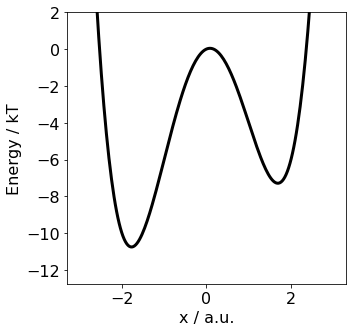

In [13]:
params = DoubleWell.params_default.copy()
params['dim'] = 2
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();
#plt.savefig(paper_dir + 'figs/doublewell_potential.pdf', bbox_inches='tight')

Text(0,0.5,'$x_2$ / a.u.')

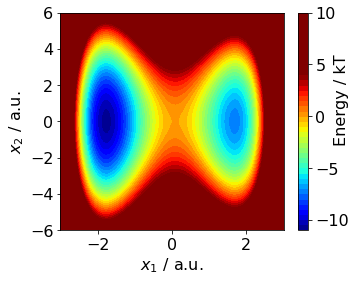

In [14]:
# 2D potential
xgrid = np.linspace(-3, 3, 100)
ygrid = np.linspace(-6, 6, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
E = double_well.energy(X)
E = E.reshape((100, 100))
E = np.minimum(E, 10.0)
plt.figure(figsize=(5, 4))
plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
cbar = plt.colorbar()
cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
cbar.set_ticks([-10, -5, 0, 5, 10])
plt.xlabel('$x_1$ / a.u.')
plt.ylabel('$x_2$ / a.u.')
#plt.savefig(paper_dir + 'figs/doublewell_potential2D.pdf', bbox_inches='tight')

In [15]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [16]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

Text(0.5,0,'Probability')

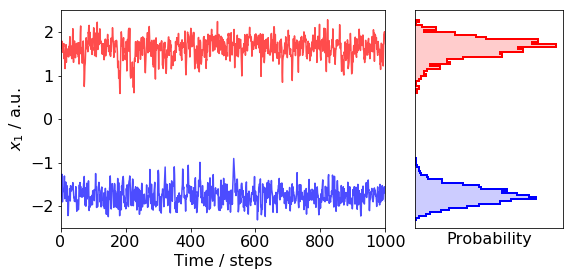

In [17]:
plt.figure(figsize=(9, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(traj_left[:, 0], color='blue', alpha=0.7)
ax1.plot(traj_right[:, 0], color='red', alpha=0.7)
ax1.set_xlim(0, 1000)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('$x_1$ / a.u.')
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Probability')
#plt.savefig(paper_dir + 'figs/doublewell_prior_trajs.pdf', bbox_inches='tight')

In [18]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

In [19]:
# prepare transition state
x_ts = np.vstack([np.zeros(1000), (1.0/double_well.params['k']) * np.random.randn(1000)]).T

Estimate transition rate
----

In [142]:
params

{'a1': 1.0, 'a2': 6.0, 'a4': 1.0, 'dim': 2, 'k': 1.0}

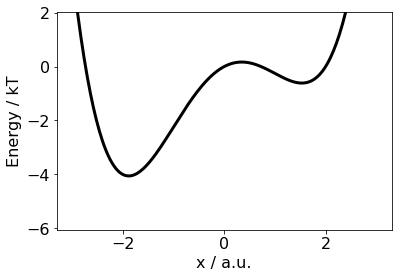

In [149]:
# change barrier but keep a/b
params_flat = params.copy()
params_flat['a2'] = 1.5
params_flat['a4'] = 0.25
double_well_flat = DoubleWell(params=params_flat)
double_well_flat.plot_dimer_energy();
#double_well_flat.plot_dimer_energy();

In [167]:
sampler = MetropolisGauss(double_well_flat, x0_left, noise=0.1, stride=100)
nstep = 1000000
sampler.run(nstep)

In [168]:
barrier_double_well = double_well.energy(np.array([[0, 0]])) - double_well.energy(np.array([[-2, 0]]))
barrier_double_well_flat = double_well_flat.energy(np.array([[0, 0]])) - double_well_flat.energy(np.array([[-2, 0]]))

In [171]:
from deep_boltzmann.util import count_transitions
Ntrans_low_barrier = count_transitions(sampler.traj[:, 0], -1, 1)
rate_low_barrier = float(Ntrans_low_barrier) / float(nstep)
dE = barrier_double_well - barrier_double_well_flat
rate_high_barrier = rate_low_barrier * np.exp(-dE)
print(1.0/rate_high_barrier)
#plt.plot(sampler.traj[:, 0])

[4034287.93492735]


Validate Umbrella Sampling + BAR
------

In [11]:
from deep_boltzmann.sampling import MetropolisGauss, UmbrellaSampling

In [307]:
sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
def rc_x(x):
    return x[:, 0]
us = UmbrellaSampling(double_well, sampler, rc_x, x0_left, 20, 50, -2.5, 2.5, forward_backward=True)
us.run(25000)

Umbrella 1 / 40
Umbrella 2 / 40
Umbrella 3 / 40
Umbrella 4 / 40
Umbrella 5 / 40
Umbrella 6 / 40
Umbrella 7 / 40
Umbrella 8 / 40
Umbrella 9 / 40
Umbrella 10 / 40
Umbrella 11 / 40
Umbrella 12 / 40
Umbrella 13 / 40
Umbrella 14 / 40
Umbrella 15 / 40
Umbrella 16 / 40
Umbrella 17 / 40
Umbrella 18 / 40
Umbrella 19 / 40
Umbrella 20 / 40
Umbrella 21 / 40
Umbrella 22 / 40
Umbrella 23 / 40
Umbrella 24 / 40
Umbrella 25 / 40
Umbrella 26 / 40
Umbrella 27 / 40
Umbrella 28 / 40
Umbrella 29 / 40
Umbrella 30 / 40
Umbrella 31 / 40
Umbrella 32 / 40
Umbrella 33 / 40
Umbrella 34 / 40
Umbrella 35 / 40
Umbrella 36 / 40
Umbrella 37 / 40
Umbrella 38 / 40
Umbrella 39 / 40
Umbrella 40 / 40


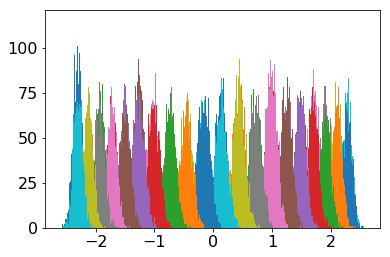

In [308]:
for rc_traj in us.rc_trajs:
    plt.hist(rc_traj, 100);

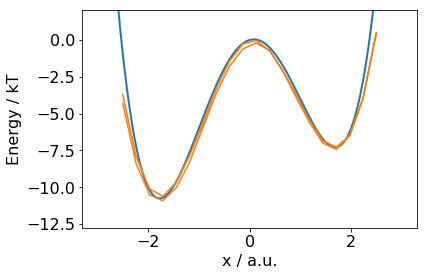

In [312]:
double_well.plot_dimer_energy();
plt.plot(us.umbrella_positions, us.umbrella_free_energies()-4.3)

Training
-------

In [20]:
def train(network, epochsZ=200, epochsE=0, wML=1.0, wKL=1.0, wW2=0.0, wRC=0.0, temperature=1.0, explore=1.0):
    # pretrain
    hist = network.train_ML(x, xval=xval, epochs=epochsZ, batch_size=128, std=1.0, verbose=0)
    
    # train
    plt.figure()  # figure for loss
    if epochsE > 0:
        nterms = 0
        if wML > 0:
            nterms +=1
        if wKL > 0:
            nterms +=1
        if wW2 > 0:
            nterms +=1
        if nterms == 1 and wKL > 0:
            hist2 = network.train_KL(lr=0.001, epochs=epochsE, batch_size=2048, explore=explore, verbose=0)
            plt.plot(hist2)
        else:
            hist2 = network.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, batch_size=2048, std=1.0,
                                           weight_ML=wML, weight_KL=wKL, weight_MC=0.0, weight_W2=wW2,
                                           weight_RCEnt=wRC, rc_func=getx, rc_min=-2.5, rc_max=2.5,
                                           temperature=temperature, explore=explore, verbose=0)
            for i in range(nterms):
                plt.plot(hist2[1][:, i+1])
                plt.plot(hist2[2][:, i+1])
    else:
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
    
    print('std_z', network.std_z(x))
    print('std_z_val', network.std_z(xval))
    
    # plot densities
    fig, axes = test_xz_projection(network.Txz, [traj_left, x_ts, traj_right], 
                                   rctrajs=[traj_left[:, 0], x_ts[:, 0], traj_right[:, 0]],
                                   colors=['blue', 'orange', 'red']);
    axes[1].set_xlim(-5, 5)
    axes[1].set_ylim(-5, 5) 
    
    # plot sample
    test_sample(network)
    test_sample_rew(network)

In [21]:
def plot_network(network, weight_cutoff=1e-2):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3.5))
    plt.subplots_adjust(wspace=0.25)
    # Plot X distribution
    axis = axes[0]
    axis.plot(traj_left[:, 0], traj_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(x_ts[:, 0], x_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(traj_right[:, 0], traj_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    axis.set_xlabel('$x_1$')
    axis.set_xlim(-3, 3)
    axis.set_ylabel('$x_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    # Plot Z distribution
    axis = axes[1]
    z_left = network.transform_xz(traj_left)
    z_ts = network.transform_xz(x_ts)
    z_right = network.transform_xz(traj_right)
    axis.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(z_ts[:, 0], z_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
    axis.add_artist(circle)
    axis.set_xlabel('$z_1$')
    axis.set_xlim(-4, 4)
    axis.set_ylabel('$z_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    # Plot proposal distribution
    X1, Y1 = test_sample(network, temperature=1.0, plot=False);
    _, W1 = hist_weights(network)
    axis = axes[2]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    Y1 = Y1 - Y1.min() + E.min()
    Inan = np.where(W1 < weight_cutoff)
    Y1[Inan] = np.nan
    #Y2 = Y2 - Y2.min() + E.min()
    #axis.plot(X2, Y2, color='#FF6600', linewidth=2, label='ML+KL+RC')
    axis.plot(X1, Y1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([]);
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('Energy / kT')
    #plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
    # Plot reweighted distribution
    RX1, RY1, DR1 = test_sample_rew(network, temperature=1.0, plot=False);
    axis = axes[3]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    RY1 = RY1 - RY1[np.isfinite(RY1)].min() + E.min()
    RY1[Inan] = np.nan
    #RY1[RY1 > -4] = np.nan
    #RY2 = RY2 - RY2[np.isfinite(RY2)].min() + E.min()
    #axis.errorbar(RX2, RY2, DR2, color='#FF6600', linewidth=2, label='ML+KL+RC')
    axis.errorbar(RX1, RY1, DR1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('')
    return fig, axes

ML training
------

std_z 0.9972208
std_z_val 0.95539653


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.28102306208248273


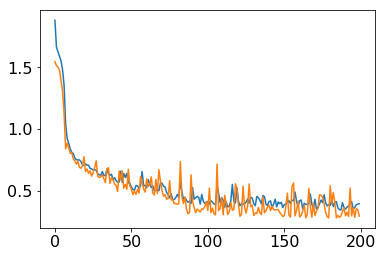

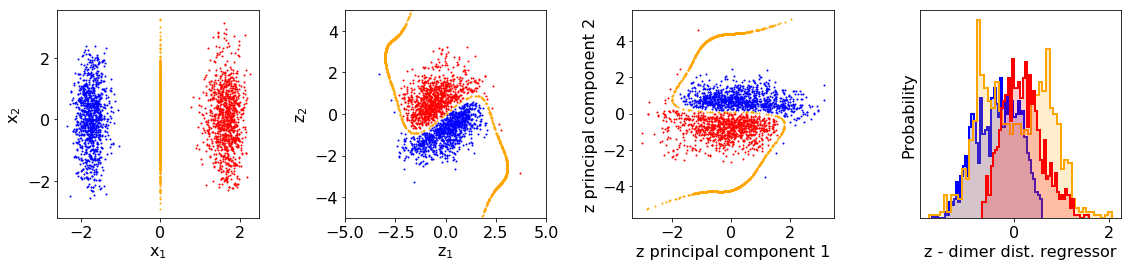

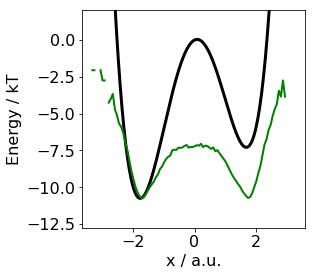

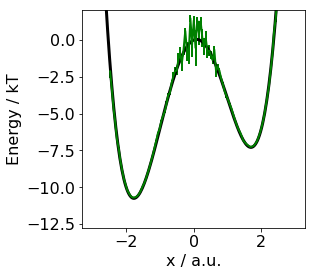

In [20]:
network_NICER_ML = create_NICERNet(double_well, nl_activation='tanh')
train(network_NICER_ML, epochsZ=200, epochsE=0, wML=1.0, wKL=1.0, wW2=0.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.29296454640183267


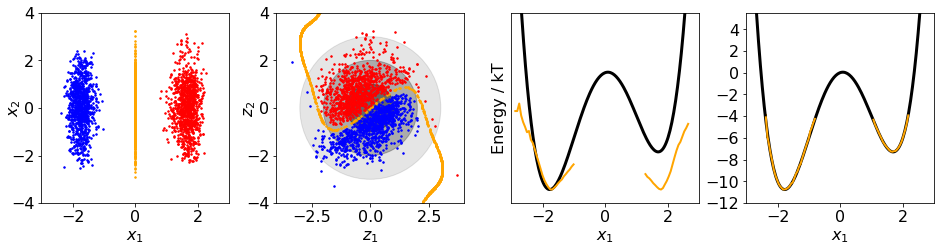

In [114]:
fig, axes = plot_network(network_NICER_ML, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_NICER_ML.pdf', bbox_inches='tight')

std_z 0.9915779
std_z_val 0.9621583


/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.8137693199707684


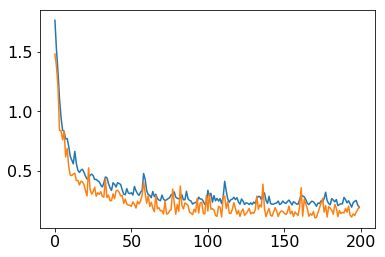

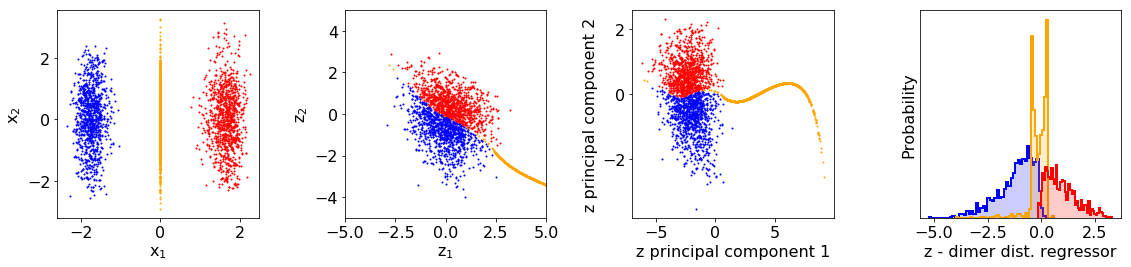

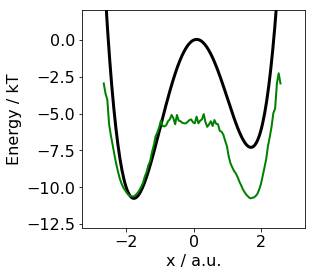

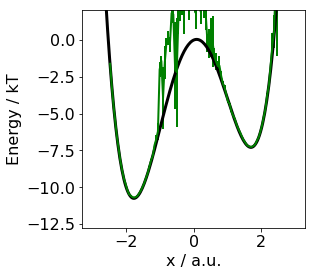

In [52]:
network_RealNVP_ML = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_ML, epochsZ=200, epochsE=0, wML=1.0, wKL=1.0, wW2=0.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.6224431010549746


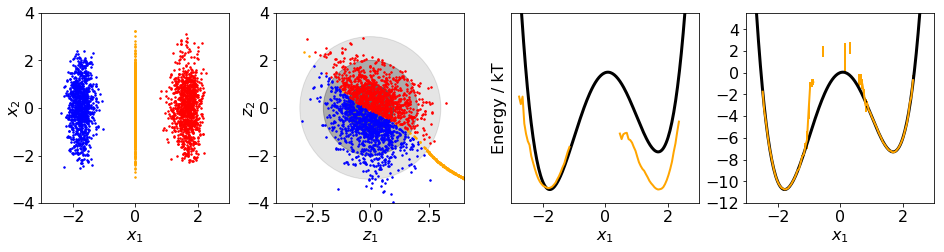

In [118]:
fig, axes = plot_network(network_RealNVP_ML, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_RealNVP_ML.pdf', bbox_inches='tight')

KL training
------

std_z 2.2273693
std_z_val 2.1512382


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.593053099008189


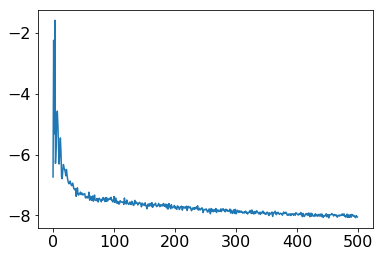

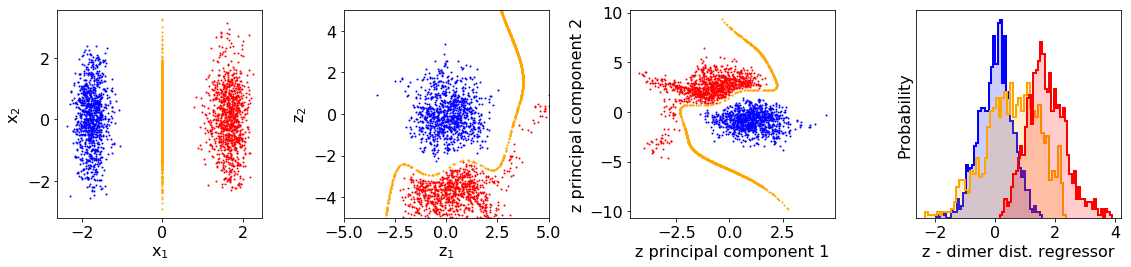

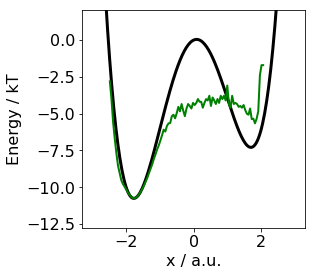

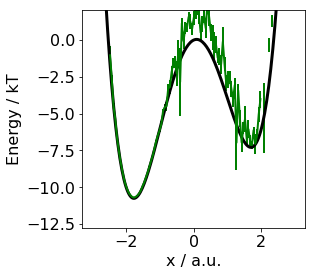

In [54]:
network_NICER_KL = create_NICERNet(double_well, nl_activation='tanh')
train(network_NICER_KL, epochsZ=200, epochsE=500, wML=0.0, wKL=1.0, wW2=0.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.6466226234951451


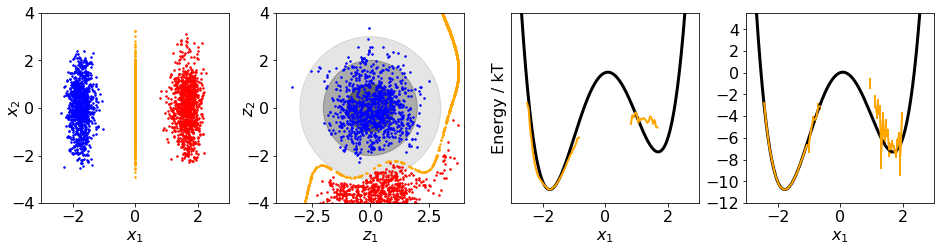

In [117]:
fig, axes = plot_network(network_NICER_KL, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_NICER_KL.pdf', bbox_inches='tight')

std_z 1.6217079
std_z_val 1.5755839


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.7276488863872477


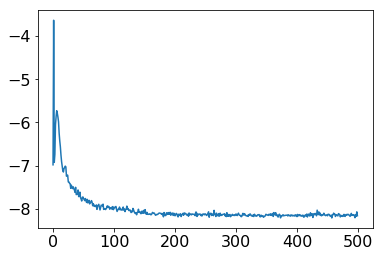

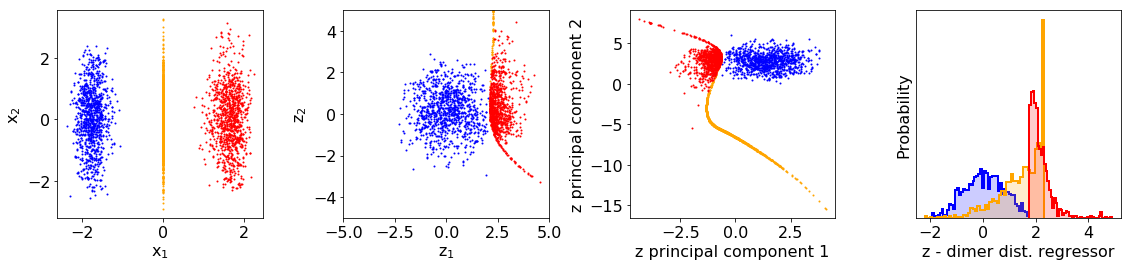

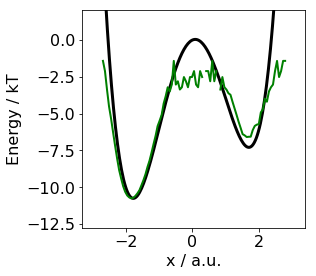

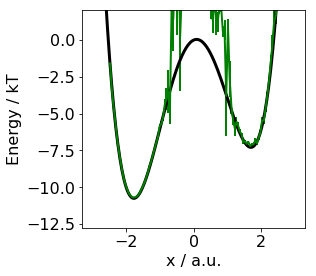

In [56]:
network_RealNVP_KL = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_KL, epochsZ=200, epochsE=500, wML=0.0, wKL=1.0, wW2=0.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.6463095487380898


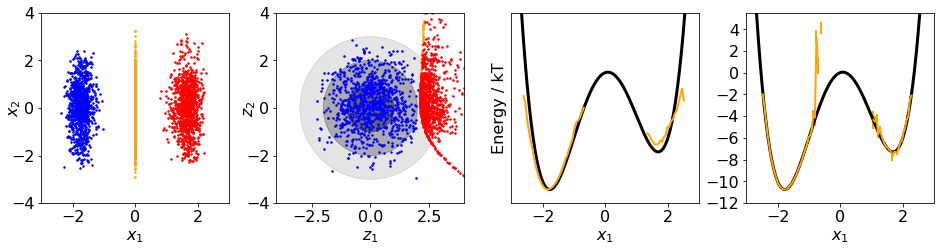

In [119]:
fig, axes = plot_network(network_RealNVP_KL, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_RealNVP_KL.pdf', bbox_inches='tight')

ML + KL
-------

std_z 1.617657
std_z_val 1.6567636


/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.4196604046835484


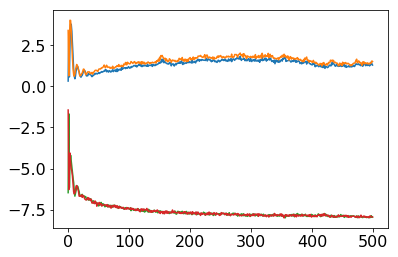

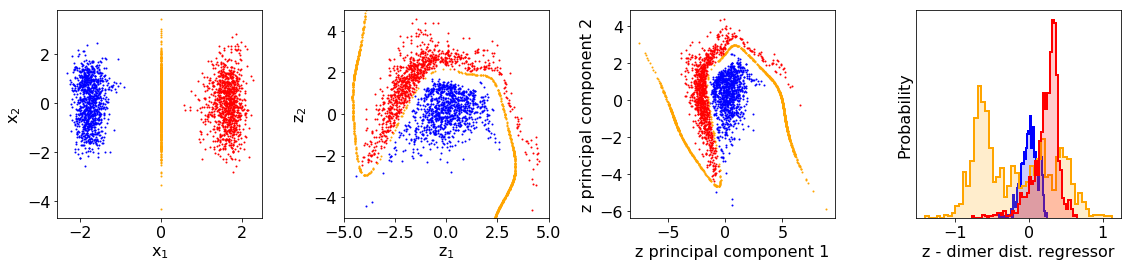

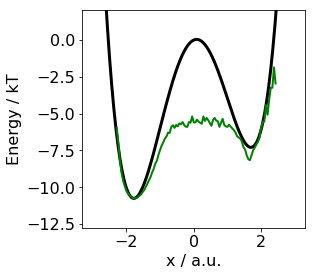

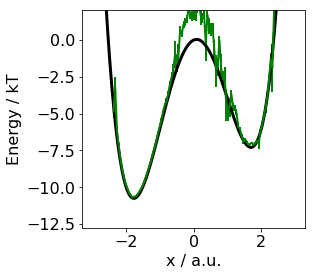

In [32]:
network_NICER_KLML_02 = create_NICERNet(double_well, nl_activation='tanh')
train(network_NICER_KLML_02, epochsZ=200, epochsE=500, wML=0.2, wKL=1.0, wW2=0.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.41248194265309446


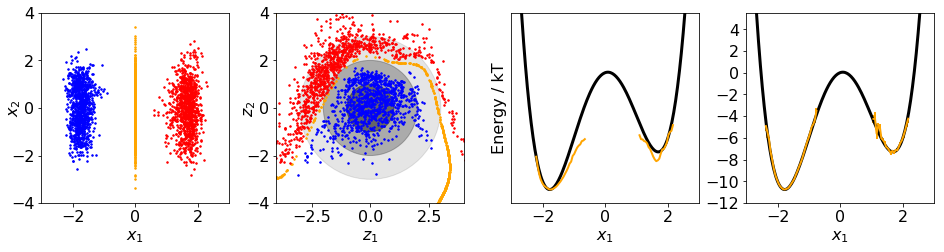

In [35]:
fig, axes = plot_network(network_NICER_KLML_02, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_NICER_KLML_02.pdf', bbox_inches='tight')

std_z 1.2199908
std_z_val 1.2565951


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.4442865566379061


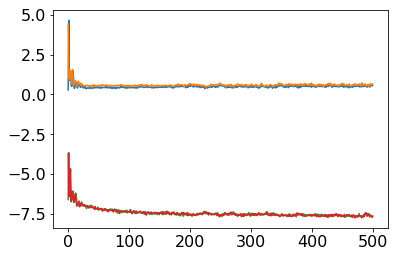

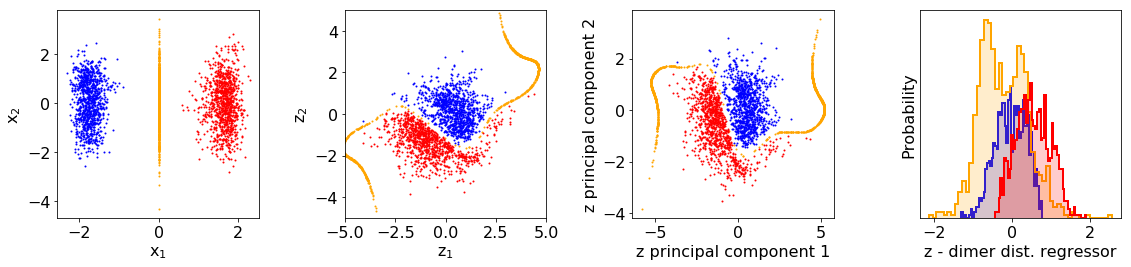

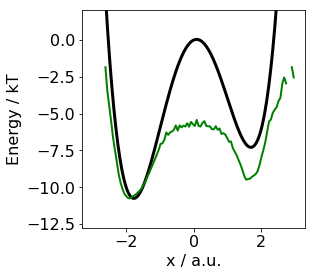

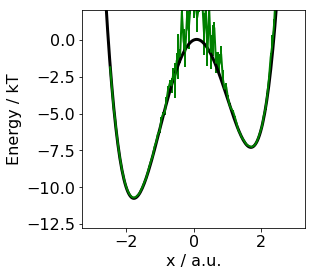

In [33]:
network_NICER_KLML = create_NICERNet(double_well, nl_activation='tanh')
train(network_NICER_KLML, epochsZ=200, epochsE=500, wML=1.0, wKL=1.0, wW2=0.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.6066104231775504


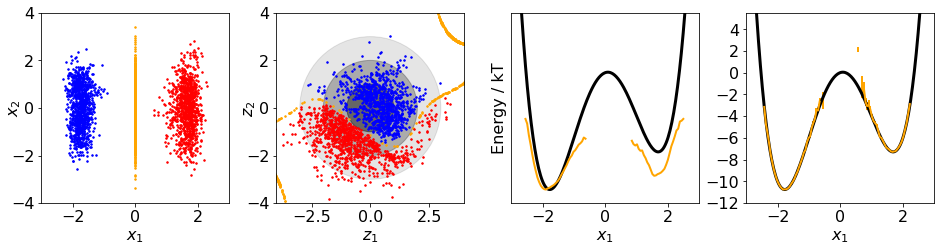

In [34]:
fig, axes = plot_network(network_NICER_KLML, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_NICER_KLML.pdf', bbox_inches='tight')

std_z 1.3023208
std_z_val 1.2876894


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.8827664771800225


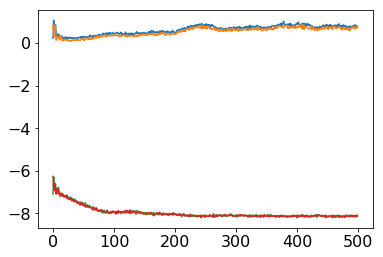

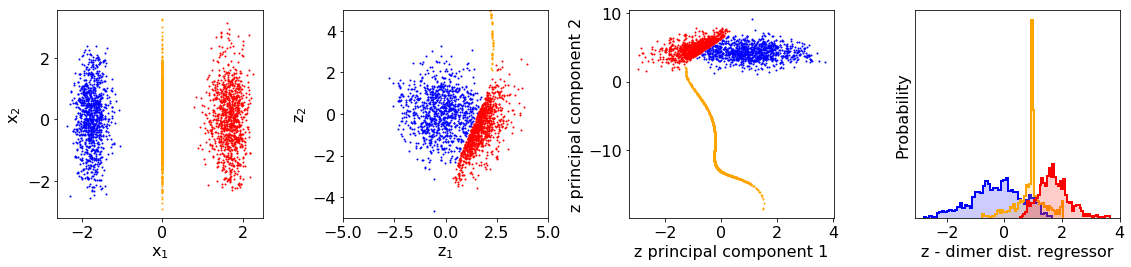

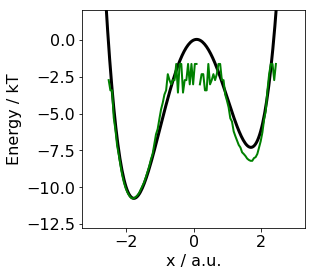

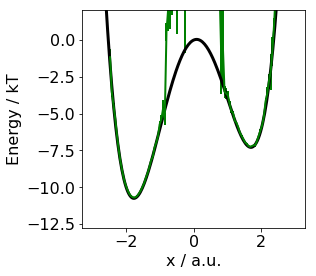

In [126]:
network_RealNVP_KLML_02 = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_KLML_02, epochsZ=200, epochsE=500, wML=0.2, wKL=1.0, wW2=0.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.8943933576381966


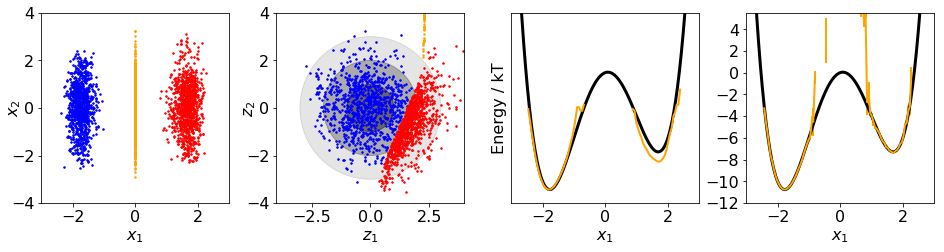

In [128]:
fig, axes = plot_network(network_RealNVP_KLML_02, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_RealNVP_KLML_02.pdf', bbox_inches='tight')

std_z 1.0353457
std_z_val 0.9901597


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.6304201597359418


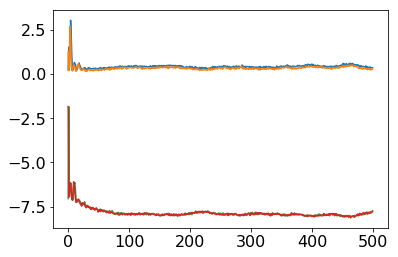

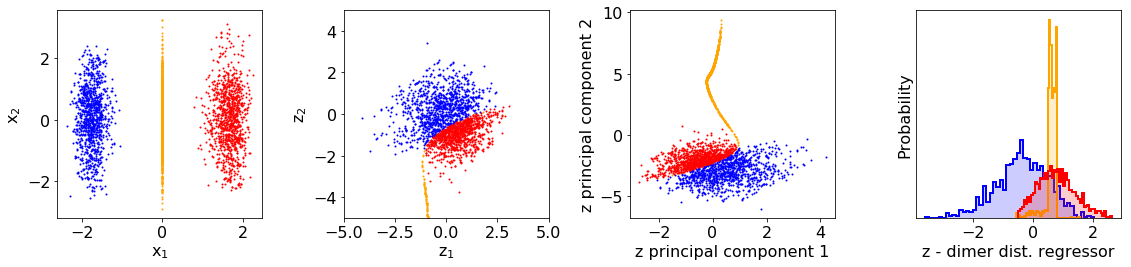

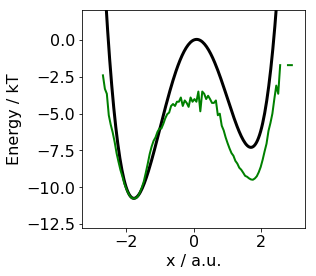

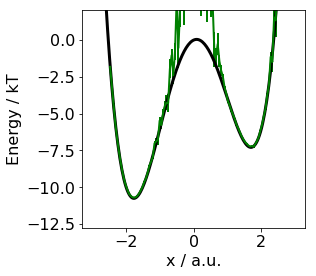

In [127]:
network_RealNVP_KLML = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_KLML, epochsZ=200, epochsE=500, wML=1.0, wKL=1.0, wW2=0.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.6138323236531594


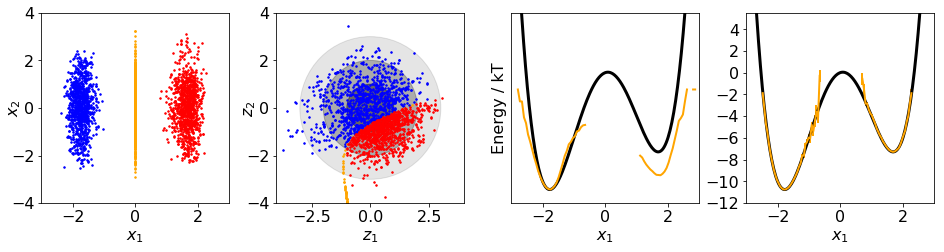

In [129]:
fig, axes = plot_network(network_RealNVP_KLML, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_RealNVP_KLML.pdf', bbox_inches='tight')

KL + explore
--------

std_z 1.0144112
std_z_val 0.9779561
Estimator Standard Error:  0.1635538933066717


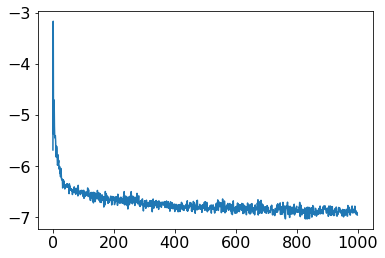

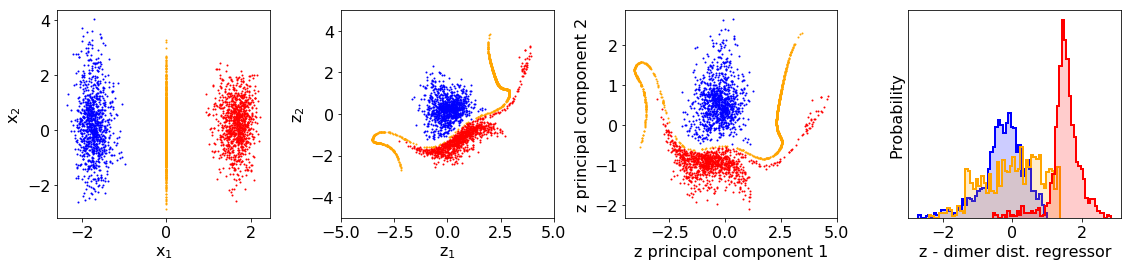

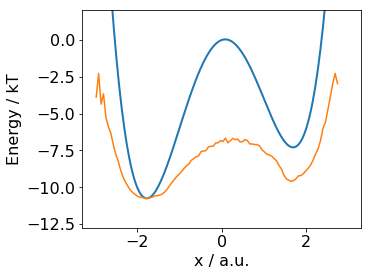

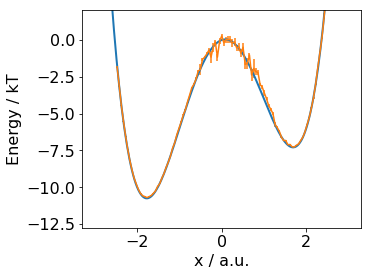

In [25]:
network_NICER_KLex = create_NICERNet(double_well, nl_activation='tanh')
train(network_NICER_KLex, epochsZ=200, epochsE=1000, wML=0.0, wKL=1.0, wW2=0.0, explore=2.5)

std_z 0.9602416
std_z_val 0.902746


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.11521079938193218


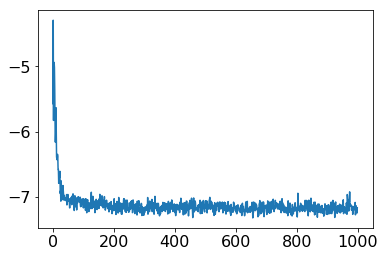

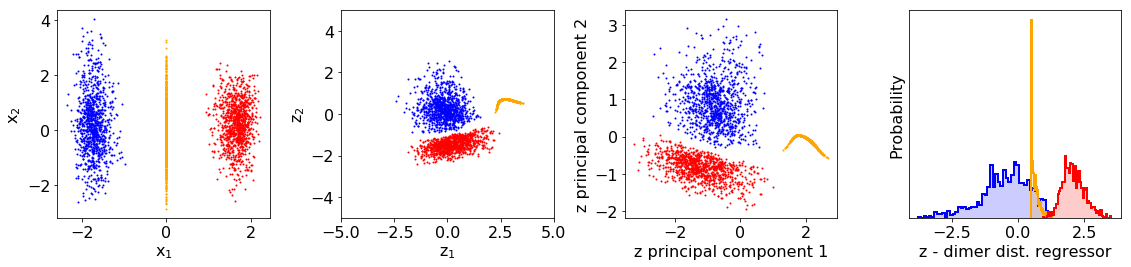

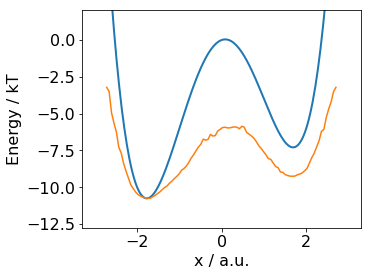

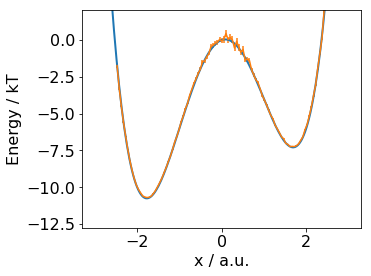

In [26]:
network_RealNVP_KLex = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_KLex, epochsZ=200, epochsE=1000, wML=0.0, wKL=1.0, wW2=0.0, explore=2.5)

KL + W2 + explore
----------------

/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'output_z_scaled_3/mul:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x_3/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x_3/GatherV2:0' shape=(?, 2) dtype=float32>]
  ' Found: ' + str(self.outputs))


std_z 1.0497417
std_z_val 1.0664978


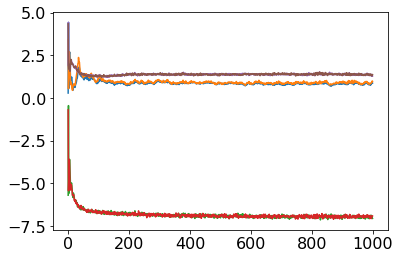

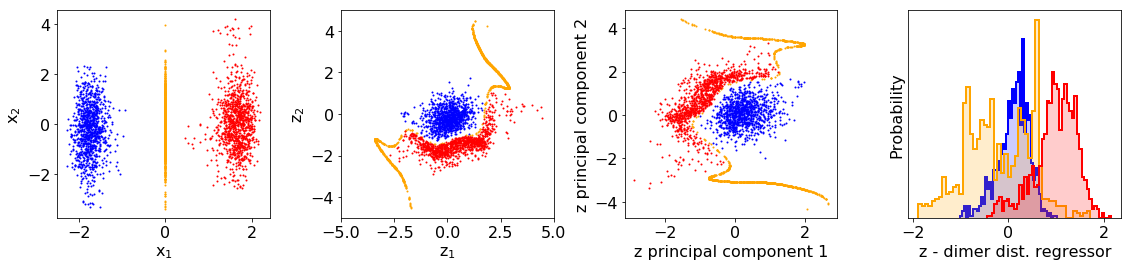

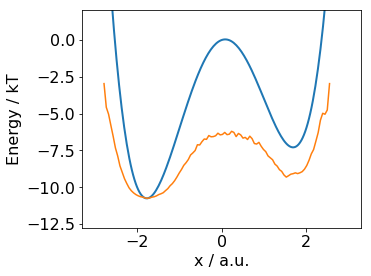

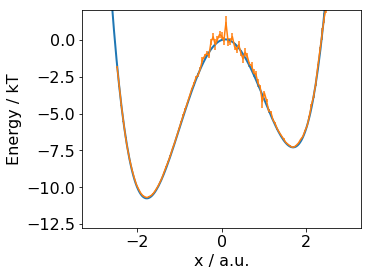

In [20]:
network_NICER_KLW2 = create_NICERNet(double_well, nl_activation='tanh')
train(network_NICER_KLW2, epochsZ=200, epochsE=1000, wML=0.001, wKL=1.0, wW2=0.2, explore=2.5)

/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'output_z_1/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x_1/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x_1/GatherV2:0' shape=(?, 2) dtype=float32>]
  ' Found: ' + str(self.outputs))


std_z 0.88825244
std_z_val 0.9892588


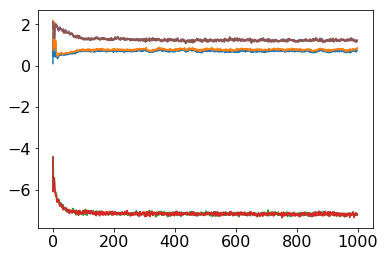

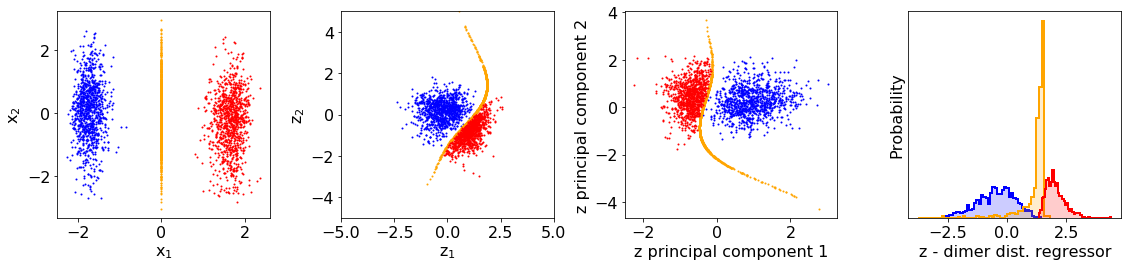

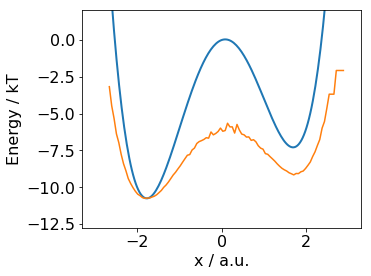

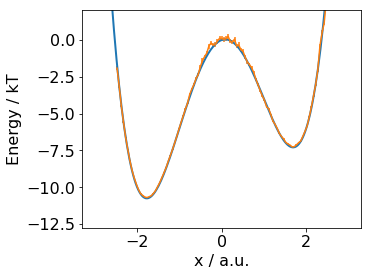

In [18]:
network_RealNVP_KLW2 = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_KLW2, epochsZ=200, epochsE=1000, wML=0.001, wKL=1.0, wW2=0.2, explore=2.5)

ML + KL + explore
----

std_z 0.83730567
std_z_val 0.8545226


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


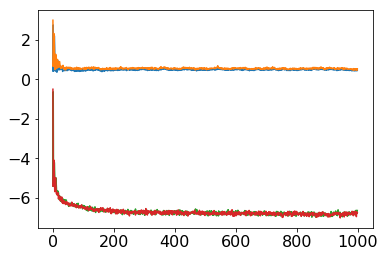

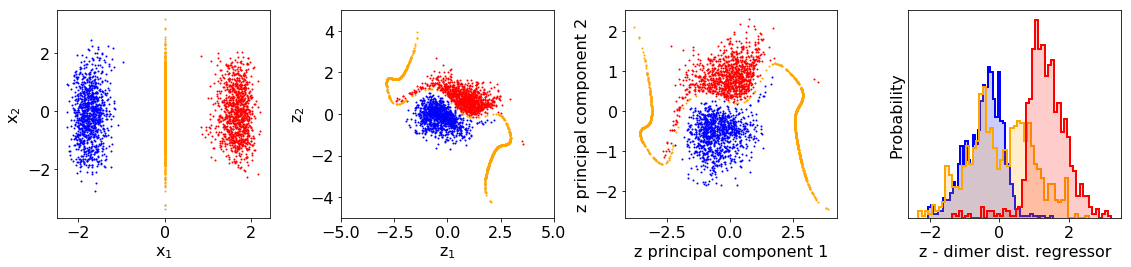

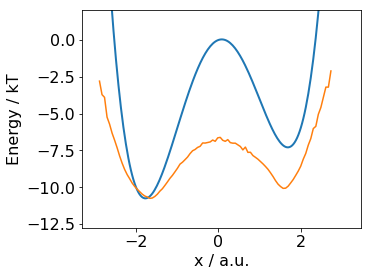

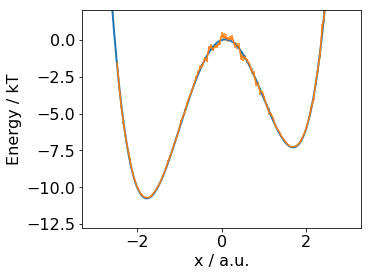

In [18]:
network_NICER_MLKLex = create_NICERNet(double_well, nl_activation='tanh')
train(network_NICER_MLKLex, epochsZ=200, epochsE=1000, wML=1.0, wKL=1.0, wW2=0.0, explore=2.5)

std_z 0.8714336
std_z_val 0.87497866


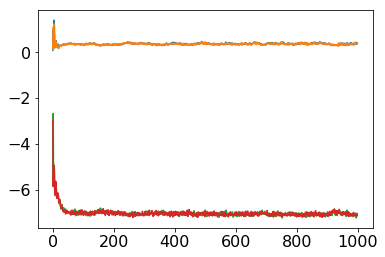

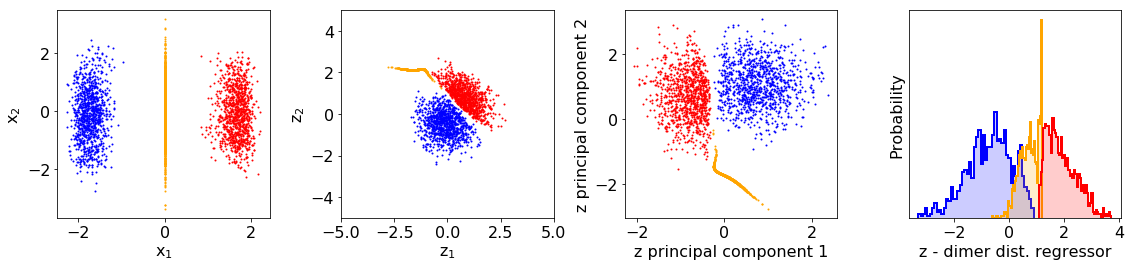

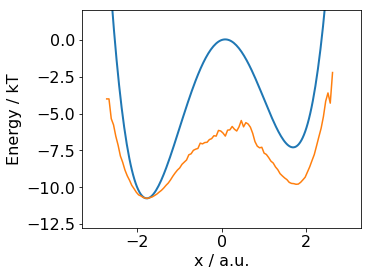

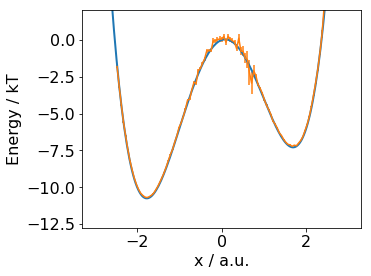

In [19]:
network_RealNVP_MLKLex = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_MLKLex, epochsZ=200, epochsE=1000, wML=1.0, wKL=1.0, wW2=0.0, explore=2.5)

KL+RC
---

/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'output_z_scaled/mul:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x/GatherV2:0' shape=(?, 2) dtype=float32>]
  ' Found: ' + str(self.outputs))


std_z 0.8845729
std_z_val 0.94446456


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.050183773578120615


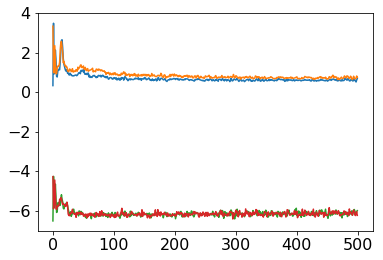

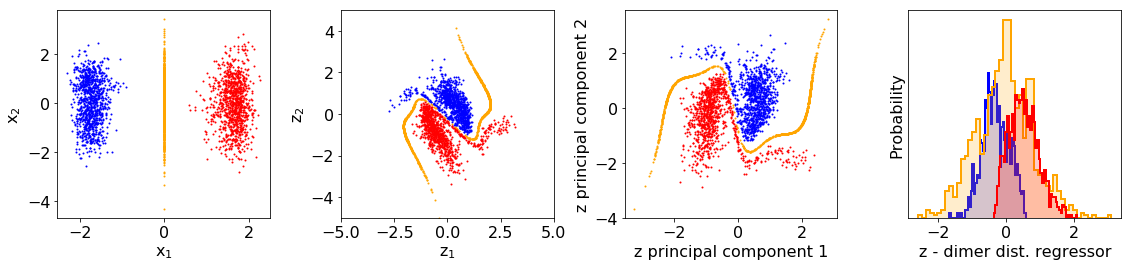

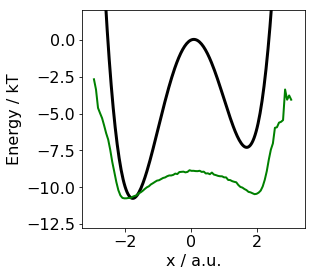

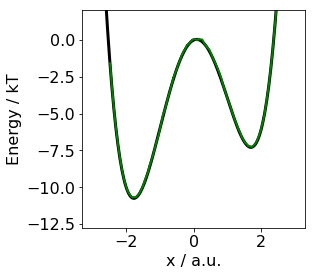

In [23]:
network_NICER_KLRC = create_NICERNet(double_well, nl_activation='tanh')
train(network_NICER_KLRC, epochsZ=200, epochsE=500, wML=0.001, wKL=1.0, wW2=0.0, wRC=1.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.049158160022288525


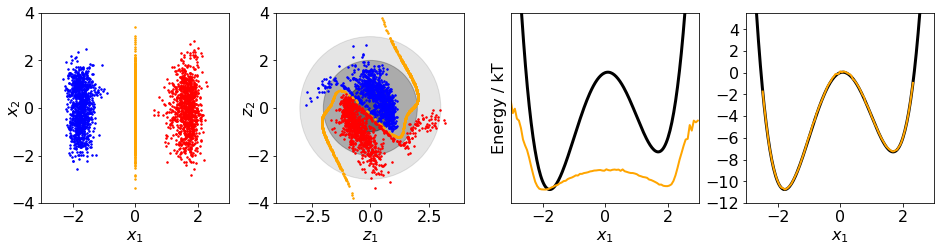

In [25]:
fig, axes = plot_network(network_NICER_KLRC, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_NICE_KLRC.pdf', bbox_inches='tight')

/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'output_z_1/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x_1/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x_1/GatherV2:0' shape=(?, 2) dtype=float32>]
  ' Found: ' + str(self.outputs))


std_z 0.90449345
std_z_val 0.95066696


/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.13922493003462635


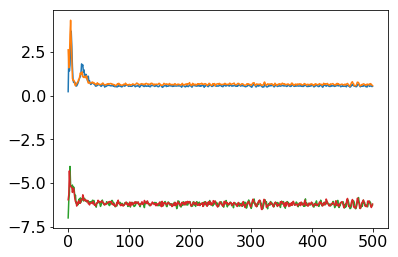

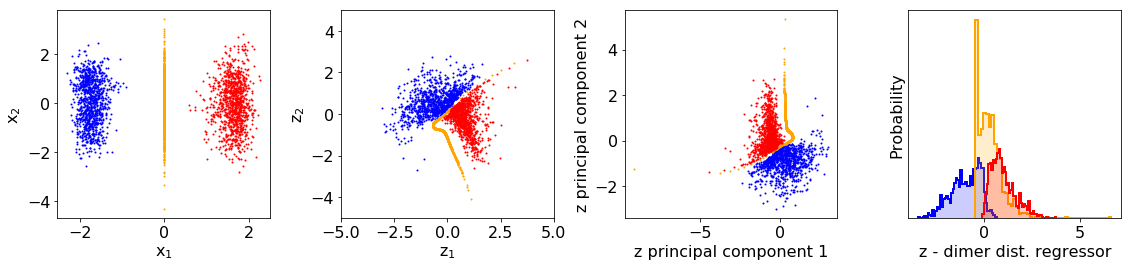

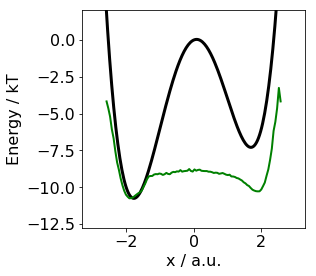

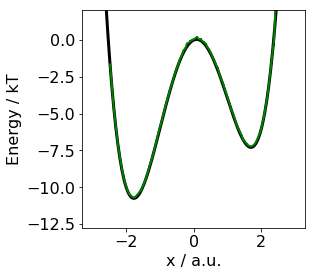

In [24]:
network_RealNVP_KLRC = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_KLRC, epochsZ=200, epochsE=500, wML=0.001, wKL=1.0, wW2=0.0, wRC=1.0, explore=1.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.09007726496742179


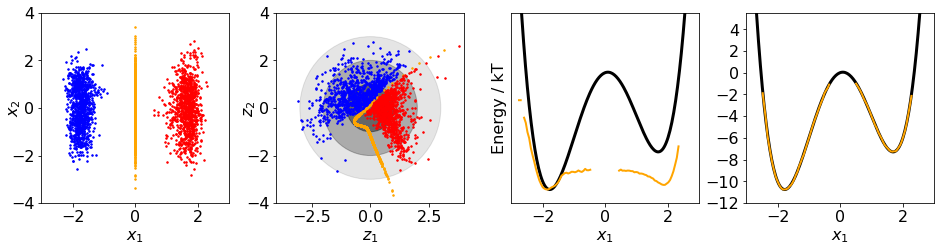

In [26]:
fig, axes = plot_network(network_RealNVP_KLRC, weight_cutoff=1e-2);
fig.savefig(paper_dir + 'figs/doublewell_Suppl_RealNVP_KLRC.pdf', bbox_inches='tight')

**Save Figures**

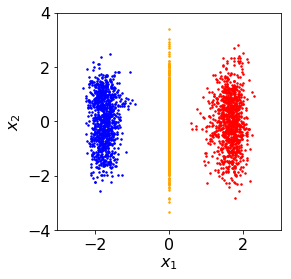

In [27]:
plt.figure(figsize=(4, 4))
plt.plot(traj_left[:, 0], traj_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
plt.plot(x_ts[:, 0], x_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
plt.plot(traj_right[:, 0], traj_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
plt.xlabel('$x_1$')
plt.xlim(-3, 3)
plt.ylabel('$x_2$')
plt.ylim(-4, 4)
plt.yticks([-4, -2, 0, 2, 4]);
plt.savefig(paper_dir + 'figs/doublewell_xdist.pdf', bbox_inches='tight')

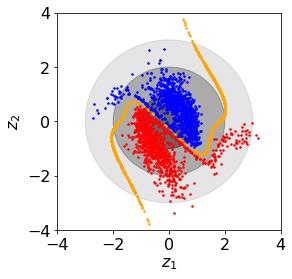

In [28]:
z_left = network_NICER_KLRC.transform_xz(traj_left)
z_ts = network_NICER_KLRC.transform_xz(x_ts)
z_right = network_NICER_KLRC.transform_xz(traj_right)
plt.figure(figsize=(4, 4))
plt.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
plt.plot(z_ts[:, 0], z_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
plt.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
plt.gca().add_artist(circle)
plt.xlabel('$z_1$')
plt.xlim(-4, 4)
plt.ylabel('$z_2$')
plt.ylim(-4, 4)
plt.yticks([-4, -2, 0, 2, 4]);
plt.savefig(paper_dir + 'figs/doublewell_zdist_NICER.pdf', bbox_inches='tight')

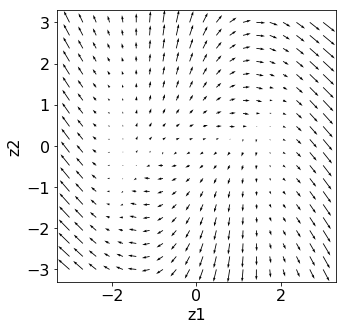

In [136]:
plot_transformation_field_2d(network_NICER_KLRC.Txz, [-3, 3, -3, 3], ngrid=20)
plt.xlabel('z1');
plt.ylabel('z2');

In [36]:
X1, Y1 = test_sample(network_NICER_KLML, temperature=1.0, plot=False);
X2, Y2 = test_sample(network_NICER_KLRC, temperature=1.0, plot=False);

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


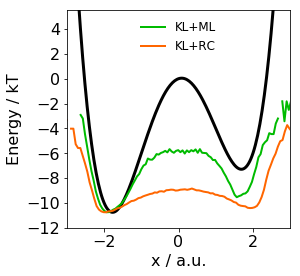

In [37]:
plt.figure(figsize=(4,4))
Ex, E = double_well.plot_dimer_energy(temperature=1.0)
Y1 = Y1 - Y1.min() + E.min()
Y2 = Y2 - Y2.min() + E.min()
plt.plot(X1, Y1, color='#00BB00', linewidth=2, label='KL+ML')
plt.plot(X2, Y2, color='#FF6600', linewidth=2, label='KL+RC')
plt.xlim(-3, 3)
plt.ylim(-12, 5.5)
plt.yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)
plt.savefig(paper_dir + 'figs/doublewell_energy_px.pdf', bbox_inches='tight')

In [39]:
RX1, RY1, DR1 = test_sample_rew(network_NICER_KLML, temperature=1.0, plot=False);
RX2, RY2, DR2 = test_sample_rew(network_NICER_KLRC, temperature=1.0, plot=False);

Estimator Standard Error:  0.534015825778978
Estimator Standard Error:  0.049950272114106783


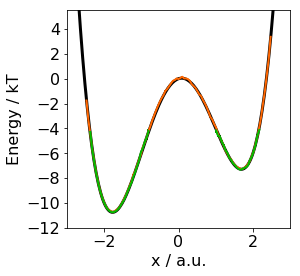

In [40]:
#test_sample_rew(network_NICER_KLRC, temperature=1.0);
plt.figure(figsize=(4,4))
Ex, E = double_well.plot_dimer_energy(temperature=1.0)
RY1 = RY1 - RY1[np.isfinite(RY1)].min() + E.min()
RY1[RY1 > -4] = np.nan
RY2 = RY2 - RY2[np.isfinite(RY2)].min() + E.min()
plt.errorbar(RX2, RY2, DR2, color='#FF6600', linewidth=2, label='ML+KL+RC')
plt.errorbar(RX1, RY1, DR1, color='#00BB00', linewidth=2, label='ML+KL')
plt.xlim(-3, 3)
plt.ylim(-12, 5.5)
plt.yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4]);
plt.savefig(paper_dir + 'figs/doublewell_energy_rew.pdf', bbox_inches='tight')

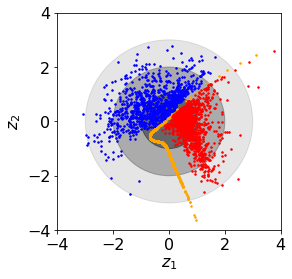

In [41]:
z_left = network_RealNVP_KLRC.transform_xz(traj_left)
z_ts = network_RealNVP_KLRC.transform_xz(x_ts)
z_right = network_RealNVP_KLRC.transform_xz(traj_right)
plt.figure(figsize=(4, 4))
plt.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
plt.plot(z_ts[:, 0], z_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
plt.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
plt.gca().add_artist(circle)
plt.xlabel('$z_1$')
plt.xlim(-4, 4)
plt.ylabel('$z_2$')
plt.ylim(-4, 4)
plt.yticks([-4, -2, 0, 2, 4]);
plt.savefig(paper_dir + 'figs/doublewell_zdist_realNVP.pdf', bbox_inches='tight')

Multiple Temperature
--------

std_z 1.5877676
std_z_val 1.6668178


/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.46879202293479405


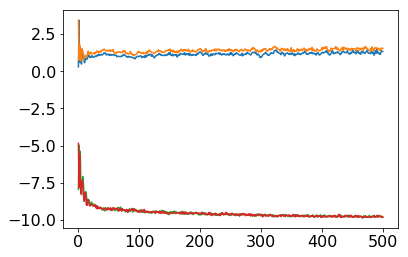

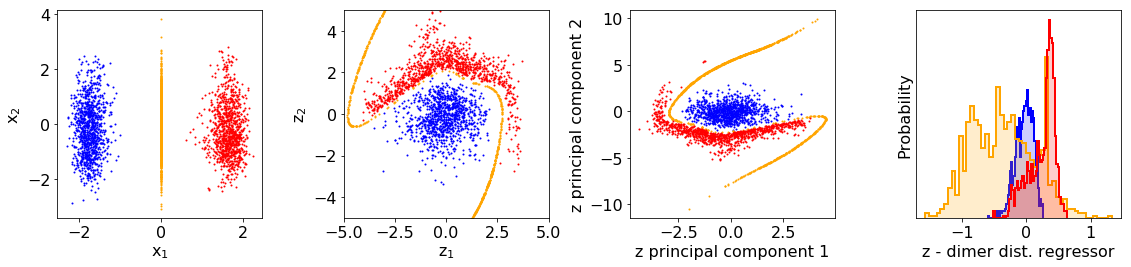

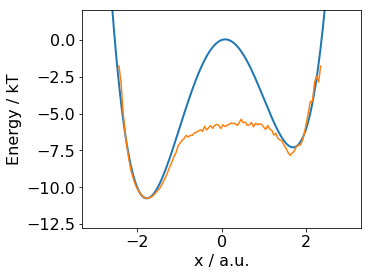

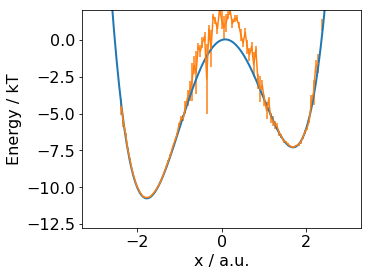

In [25]:
network_NICER_MLKLMult = create_NICERNet(double_well, nl_activation='tanh')
train(network_NICER_MLKLMult, epochsZ=200, epochsE=500, 
      wML=0.2, wKL=1.0, wW2=0.0, wRC=0.0, temperature=[0.5, 1.0, 2.0])

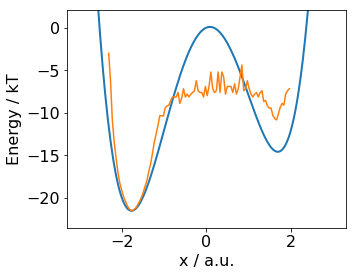

In [30]:
test_sample(network_NICER_MLKLMult, temperature=0.5);

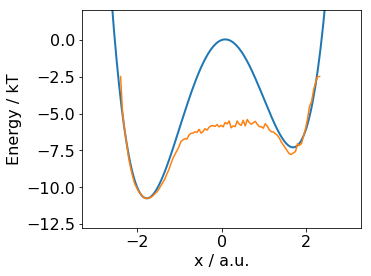

In [29]:
test_sample(network_NICER_MLKLMult, temperature=1.0);

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


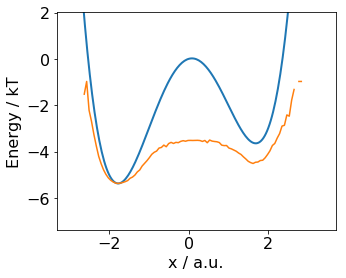

In [28]:
test_sample(network_NICER_MLKLMult, temperature=2.0);